In [2]:
#
import matplotlib.pyplot as plt
import numpy as np
import time

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import pandas_datareader.data as web
import pandas as pd
import datetime as dt

import bs4 as bs
import pickle
import requests

In [3]:
# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

In [4]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,"lxml")
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open("sp500tickers.pickle","wb") as f: #wb = write binary
        pickle.dump(tickers,f)
    print(tickers)
    return tickers

In [7]:
def LSTM_Data_Prepare(matrix_vix):
    # random seed
    np.random.seed(1234)
    # split dataset: 90% for training and 10% for testing
    train_row = int(round(0.9 * matrix_vix.shape[0]))
    train_set = matrix_vix[:train_row]

    # shuffle the training set (but do not shuffle the test set)
    np.random.shuffle(train_set)

    # the training set
    X_train = train_set[:, :-1]

    # the last column is the true value to compute the mean-squared-error loss
    y_train = train_set[:, -1] 


    # the test set
    X_test = matrix_vix[train_row:, :-1]
    y_test = matrix_vix[train_row:, -1]

    # the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return train_row,X_train, X_test, y_train, y_test

def LSTM_Train(X_train, X_test, y_train, y_test):
    ts_start = time.time()
    # build the model
    model = Sequential()
    # layer 1: LSTM
    model.add(LSTM(input_dim=1, output_dim=50, return_sequences=True))
    model.add(Dropout(0.2))
    # layer 2: LSTM
    model.add(LSTM(output_dim=50, return_sequences=False))
    model.add(Dropout(0.2))
    # layer 3: dense
    # linear activation: a(x) = x
    model.add(Dense(output_dim=1, activation='linear'))
    # compile the model
    model.compile(loss="mse", optimizer="rmsprop")

    # train the model
    model.fit(X_train, y_train, batch_size=512, nb_epoch=50, validation_split=0.05, verbose=1)

    # evaluate the result
    test_mse = model.evaluate(X_test, y_test, verbose=1)
    print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

    # get the predicted values
    predicted_values = model.predict(X_test)
    num_test_samples = len(predicted_values)
    predicted_values = np.reshape(predicted_values, (num_test_samples,1))


    ts_end = time.time()
    print ('\nProcess start: ' + dt.datetime.fromtimestamp( ts_start ).strftime('%Y-%m-%d %H:%M:%S:%f'))
    print ('\nProcess end: ' + dt.datetime.fromtimestamp( ts_end ).strftime('%Y-%m-%d %H:%M:%S:%f'))
    print ('\nTime spent: ' + str(ts_end - ts_start) +'s')
    
    return predicted_values, y_test


In [26]:
def pov(s,s0):
    w = 10000000.00
    pct_volume = 0.002
    quantity = 0.0
    pnl = 0.0
    trades = pd.DataFrame(columns = ['price','shares','b/s','cash','stock','ret'], index = s0.index)
    counter  = 0
    for index, row in s0.iterrows():
        volume = row['volume']
        if counter >= len(s)-1:
            break
        if float(s[counter+1]) > float(s[counter]):
            quantity_remaining = np.floor(w / row['close'])             
            new_trade = min(np.floor(pct_volume * volume), quantity_remaining)
            quantity += new_trade
            w -= new_trade * row['close']
            pnl = w + quantity * row['close'] 
            trades.loc[index] = [row['close'], new_trade, 'b', w, quantity, pnl]
        elif float(s[counter+1]) < float(s[counter]):
            new_trade = min(np.floor(pct_volume * volume), quantity)
            quantity -= new_trade
            w += new_trade * row['close']
            pnl = w + quantity * row['close'] 
            trades.loc[index] = [row['close'], new_trade, 's', w, quantity, pnl]
        else:
            pnl = w + quantity * row['close'] 
            trades.loc[index] = [row['close'], 0, '-', w, quantity, pnl]
        counter += 1
    return trades
            
def buy_n_hold(s0):
    w = 10000000.00
    pct_volume = 0.002
    quantity = 0.0
    pnl = 0.0
    trades = pd.DataFrame(columns = ['price','shares','b/s','cash','stock','ret'], index = s0.index)
    counter  = 0
    for index, row in s0.iterrows():
        volume = row['volume']
        if counter >= len(s)-1:
            break
        quantity_remaining = np.floor(w / row['close'])
        new_trade = min(np.floor(pct_volume * volume), quantity_remaining)
        quantity += new_trade
        w -= new_trade * row['close']
        pnl = w + quantity * row['close'] 
        trades.loc[index] = [row['close'], new_trade, 'b', w, quantity, pnl]
    return trades

In [21]:
# load the data
data_vix = web.DataReader('NTRI', data_source = 'iex', start ='7/1/2014', end = '6/30/2018')
data_s = web.DataReader('WTW', data_source = 'iex', start = '7/1/2014', end = '6/30/2018')

print (data_s)
# data_s = web.DataReader('AAPL', data_source = 'yahoo', start = '1/1/2005', end = '3/20/2018')
sequence_length = 20
product = 'stock'

# vector to store the time series
vector_vix = data_vix['close'].values.tolist()
daily_pct_change = np.log(data_s['close']/data_s['close'].shift(1))
daily_rv = 10000 * 252 * np.cumsum(daily_pct_change ** 2) / np.arange(len(daily_pct_change))

daily_pct_change = daily_pct_change[1:,]
daily_rv = daily_rv[1:,]

# convert the vector to a 2D matrix
if product == 'stock':
    matrix_vix = convertSeriesToMatrix(daily_pct_change, sequence_length)
elif product == 'vix':
    matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)
else:
    matrix_vix = convertSeriesToMatrix(daily_rv, sequence_length)


              open      high       low   close   volume
date                                                   
2014-07-01   20.19   20.5200   20.1900   20.46   570992
2014-07-02   20.42   20.7100   20.3500   20.40   346568
2014-07-03   20.44   20.5900   20.1300   20.13   742673
2014-07-07   20.32   20.4700   20.1300   20.45   851734
2014-07-08   20.47   20.6400   20.2100   20.33   540221
2014-07-09   20.41   20.9800   20.3500   20.91   575253
2014-07-10   20.72   20.7499   20.2100   20.25   570309
2014-07-11   20.26   20.3200   19.9600   20.00   838035
2014-07-14   20.09   20.1400   19.3000   19.50  1521933
2014-07-15   19.50   19.5000   19.0900   19.25   713956
2014-07-16   19.41   19.4800   19.1000   19.30   739309
2014-07-17   19.27   19.6290   19.1700   19.51   683642
2014-07-18   19.48   19.8300   19.3500   19.79  1111071
2014-07-21   19.74   20.1200   19.5200   20.01   556738
2014-07-22   20.12   20.7700   20.1100   20.59   907271
2014-07-23   20.64   20.7100   20.1500   20.31  

In [22]:
# shift all data by mean
matrix_vix = np.array(matrix_vix)

if product == 'stock':
    rows = matrix_vix.shape[0]
    columns = matrix_vix.shape[1]
    mean = [0.0]*rows
    std = [0.0]*rows

    for i in range(rows):
        mean[i] = matrix_vix[i].mean()
        std[i] = matrix_vix[i].std()
        for j in range(columns):
            matrix_vix[i][j] = (matrix_vix[i][j]-mean[i])/std[i]
elif product == 'vix':
    shifted_value = matrix_vix.mean()
    matrix_vix -= shifted_value
else:
    mean = [0.0]*rows
    for i in range(rows):
        mean[i] = matrix_vix[i].mean()
        for j in range(columns):
            matrix_vix[i][j] = (matrix_vix[i][j]-mean[i])

print ("Data  shape: ", matrix_vix.shape)
# print matrix_vix
# run LSTM model

train_row, X_train, X_test, y_train, y_test = LSTM_Data_Prepare(matrix_vix)
predicted_values, y_test = LSTM_Train(X_train, X_test, y_train, y_test)

Data  shape:  (988, 20)


C:\Users\Tian\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Tian\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Tian\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=50)`
C:\Users\Tian\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
C:\Users\Tian\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been 

Train on 844 samples, validate on 45 samples
Epoch 1/50
844/844 [==============================] - 1s 1ms/step - loss: 1.0761 - val_loss: 0.9052
Epoch 2/50
844/844 [==============================] - 0s 139us/step - loss: 1.0427 - val_loss: 0.8652
Epoch 3/50
844/844 [==============================] - 0s 135us/step - loss: 0.9923 - val_loss: 0.7887
Epoch 4/50
844/844 [==============================] - 0s 135us/step - loss: 0.8967 - val_loss: 0.6863
Epoch 5/50
844/844 [==============================] - 0s 143us/step - loss: 0.8000 - val_loss: 0.6687
Epoch 6/50
844/844 [==============================] - 0s 142us/step - loss: 0.7610 - val_loss: 0.6144
Epoch 7/50
844/844 [==============================] - 0s 134us/step - loss: 0.7155 - val_loss: 0.5928
Epoch 8/50
844/844 [==============================] - 0s 138us/step - loss: 0.6823 - val_loss: 0.5723
Epoch 9/50
844/844 [==============================] - 0s 135us/step - loss: 0.6713 - val_loss: 0.5624
Epoch 10/50
844/844 [==================

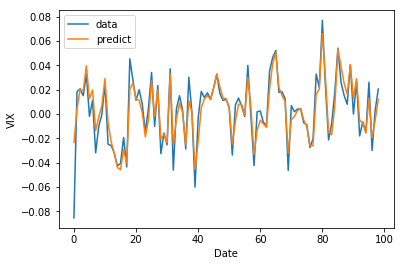

In [23]:
rows_res = len(y_test)

data = [0.0]*rows_res
predict = [0.0]*rows_res
mse = 0.0
if product == 'stock': 
    std_test = std[train_row:]
    mu_test = mean[train_row:]
    for i in range(len(std_test)):
        data[i] = y_test[i]*std_test[i]+mu_test[i]
        predict[i] = predicted_values[i]*std_test[i]+mu_test[i]
elif product == 'vix':
    data = y_test + shifted_value
    predict = predicted_values + shifted_value
else:
    mu_test = mean[train_row:]
    for i in range(len(std_test)):
        data[i] = y_test[i] + mu_test[i]
        predict[i] = predicted_values[i] + mu_test[i]
        mse += float((data[i]-predict[i])**2)
    print ("mse is " + str(mse/len(std_test)))

    data_2 = matrix_vix[train_row:,-1]

# print len(data)
# plot the results
fig = plt.figure()
# plt.plot(y_test + shifted_value, label = 'data')
# plt.plot(predicted_values + shifted_value, label = 'predict')
plt.plot(data, label = 'data')
plt.plot(predict, label = 'predict')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()
fig.savefig('output_prediction.jpg', bbox_inches='tight')

# save the result into txt file
# test_result = zip(predicted_values, y_test) + shifted_value
# np.savetxt('output_result.txt', test_result)

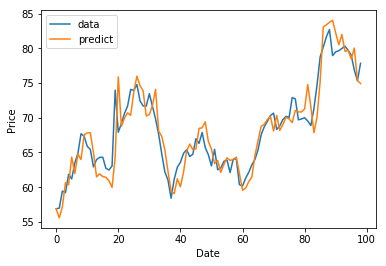


The MSE of stock price prediction is: 5.887423


In [24]:
if product == 'stock':
    s0 = data_s['close'][train_row:train_row+rows_res].values.tolist()
    s = [s0[0]]
    for i in range(len(s0)-1):
        s.append(s0[i]*np.exp(predict[i]))
    fig = plt.figure()
    plt.plot(s0, label = 'data')
    plt.plot(s, label = 'predict')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    mse = 0.0
    for i in range(rows_res):
        mse += (s0[i]-s[i])**2
    mse /= rows_res
    print ('\nThe MSE of stock price prediction is: ' + str(mse[0]))
# fig.savefig('output_prediction.jpg', bbox_inches='tight')


            price shares  b/s         cash  stock          ret  daily_ret  \
date                                                                        
2018-01-10  56.89      0    s        1e+07      0        1e+07   0.000000   
2018-01-11  56.98   3905    b  9.77749e+06   3905        1e+07   0.000000   
2018-01-12  59.44   4349    b  9.51899e+06   8254  1.00096e+07   0.000961   
2018-01-16  59.21   4662    s  9.79503e+06   3592  1.00077e+07  -0.000190   
2018-01-17  61.84   4685    b  9.50531e+06   8277  1.00172e+07   0.000944   
2018-01-18  61.19   2118    s  9.63491e+06   6159  1.00118e+07  -0.000537   
2018-01-19   63.5   4141    b  9.37195e+06  10300   1.0026e+07   0.001421   
2018-01-22  64.86   2624    s  9.54214e+06   7676    1.004e+07   0.001397   
2018-01-23   67.7   3766    b  9.28719e+06  11442  1.00618e+07   0.002171   
2018-01-24  67.34   3195    b  9.07204e+06  14637  1.00577e+07  -0.000409   
2018-01-25  65.89   5111    b  8.73527e+06  19748  1.00365e+07  -0.002110   

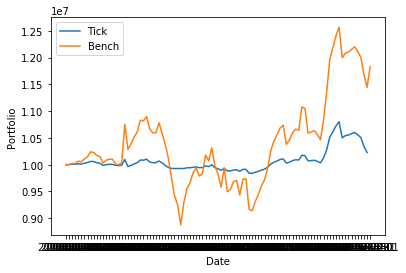

0.4495096853852894 1.3047650693762964


In [27]:
s0 = data_s[train_row:train_row+rows_res]
trade = pov(s,s0)
bench = buy_n_hold(s0)

N = 252
rfr = 0.02
bench['daily_ret'] = bench['ret'].pct_change()
trade['daily_ret'] = trade['ret'].pct_change()


trade['daily_ret']= np.nan_to_num(trade['daily_ret'])
bench['daily_ret']= np.nan_to_num(bench['daily_ret'])
trade['excess_daily_ret'] = trade['daily_ret'] - rfr/(N*1.0)
bench['excess_daily_ret'] = bench['daily_ret'] - rfr/(N*1.0)
   
strat = pd.DataFrame({'Tick':trade['daily_ret'], 'Bench':bench['daily_ret']})
strat['net_ret'] = (strat['Tick'] - strat['Bench'])/2.0

annualized_sharpe_tick = np.sqrt(N) * trade['excess_daily_ret'].mean() / trade['excess_daily_ret'].std()
annualized_sharpe_bench = np.sqrt(N) * bench['excess_daily_ret'].mean() / bench['excess_daily_ret'].std()
annualized_sharpe_excess = np.sqrt(N) * strat['net_ret'].mean() / strat['net_ret'].std()

print (trade)

fig = plt.figure()
plt.plot(trade['ret'], label = 'Tick')
plt.plot(bench['ret'], label = 'Bench')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.legend()
plt.show()

print (annualized_sharpe_tick, annualized_sharpe_bench)